**Imports**

In [39]:
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

from functions.retro_data.weather_data import get_weather
from functions.retro_data.spotprice_data import get_spotprice
from functions.retro_data.consumption_data import get_demand
from functions.calculations.calculations import calculate_energy
from functions.calculations.kpis import calculate_kpis
from functions.deciding_functions.optimized import optimize_energy_flow
from functions.deciding_functions.rulebased import rule_based_energy_flow

**Definition des Green Energy Ecosystems**

In [ ]:
# Photovoltaik
solar_peak_power = 38  # Spitzenleistung Gesamtsystem PV [MW]
num_modules = 114980 #Anzahl Solarmodule
area_per_module = 1.57458  # Fläche pro Modul [m²] (Annahme Heckert Solar NeMo® 2.0 330 Wp)
module_efficiency = 0.196  # Wirkungsgrad der Solarmodule (Annahme Heckert Solar NeMo® 2.0 330 Wp)
tilt_angle = 45  # Neigungswinkel der Solarpanels [°] (Annahme)
latitude=51.751111 
longitude=4.208611 
azimuth=180 
albedo=0.2 

# Windkraft 
wind_peak_power = 22   # Spitzenleistung Gesamtsystem Windkraft [MW]
r = 60 # Rotor Radius [m]
h = 90 # Höhe Windrad [m]
turbine_efficiency = 0.5  # Wirkungsgrad der Windkraftanlagen (Annahme)
cut_in = 2.5  # Einschaltgeschwindigkeit [m/s]
cut_out = 28  # Abschaltgeschwindigkeit [m/s]
num_turbines = 6 # Anzahl Windkraftanlagen

# Batteriespeicher
battery_capacity = 12  # MWh
soc = 0.5  # State of Charge (SOC) initial [0-1]
initial_battery = soc * battery_capacity  # MWh
charging_rate = 10  # Lade-/Entladerate [MW/h]
discharging_rate = 10

# Verbraucher
yearly_demand = 2.7  #  Verbrauch eines Haushalts/Jahr [MWh] (Annahme)
num_houses = 39000  # Anzahl Haushalte

# Strompreis
export_factor = 0.25   # Anteil vom Spotpreis für Einspeisung
price_low_quant  = 0.30   # Regelbasiert: Niedrigpreis-Schwelle

# Parameter für Sliding Window
start_month = 5  # Startmonat für das Sliding Window (1 bis 12)
start_year = 2025  # Startjahr für das Sliding Window (2024/2025)
cut_ds = 14  # Datensatz kürzen [Tage]
window_days = 7    # Länge des Fensters [Tage]
step_hours = 1    # Schrittweite [Stunden]

**Ausführen der Vorbereitungsfunktionen**

In [41]:
# Daten laden
df_weather = get_weather()
df_spot = get_spotprice()
df_demand = get_demand(num_houses, yearly_demand)
if df_weather is None or df_spot is None or df_demand is None:
    print("Abbruch.")

for df in [df_weather, df_spot, df_demand]:
    df["datetime"] = pd.to_datetime(df["datetime"])

# Liegt das Startdatum im erlaubten Zeitraum?
if (start_month < 1) or (start_month > 12) or (start_year < 2024) or (start_year > 2025) or (start_year == 2025 and start_month > 5):
    raise ValueError("Startmonat/-jahr liegt außerhalb des erlaubten Zeitraums (01.01.2024 bis 31.05.2025).")
    
# Zuschneiden der Datensätze auf gewünschten Monat und Jahr
first_of_month = df_weather[
    (df_weather["datetime"].dt.month == start_month) &
    (df_weather["datetime"].dt.year == start_year)
]["datetime"].min()
if pd.isnull(first_of_month):
    raise ValueError(f"Kein Datenpunkt für Monat {start_month} und Jahr {start_year} im Datensatz gefunden.")

start = first_of_month
end = start + pd.Timedelta(days=cut_ds)

df_weather = df_weather[(df_weather["datetime"] >= start) & (df_weather["datetime"] < end)].reset_index(drop=True)
df_spot = df_spot[(df_spot["datetime"] >= start) & (df_spot["datetime"] < end)].reset_index(drop=True)
df_demand = df_demand[(df_demand["datetime"] >= start) & (df_demand["datetime"] < end)].reset_index(drop=True)

display(df_weather.head())
print(len(df_weather))

display(df_spot.head())
print(len(df_spot))

display(df_demand.head())
print(len(df_demand))

,datetime,solarradiation,windspeed,temp,cloudcover,humidity,sealevelpressure
0,2025-05-01 00:00:00,0.0,6.7,14.2,3.9,81.94,1021.0
1,2025-05-01 01:00:00,0.0,6.1,13.8,30.0,85.49,1020.9
2,2025-05-01 02:00:00,0.0,6.2,12.9,100.0,90.00,1020.6
3,2025-05-01 03:00:00,0.0,6.1,11.7,65.0,93.30,1020.5
4,2025-05-01 04:00:00,0.0,5.5,11.4,61.2,94.96,1020.3


744


,datetime,spotprice
0,2025-05-01 00:00:00,97.51
1,2025-05-01 01:00:00,91.78
2,2025-05-01 02:00:00,90.46
3,2025-05-01 03:00:00,90.63
4,2025-05-01 04:00:00,90.50


744


,datetime,energy_demand
0,2025-05-01 00:00:00,9.325286
1,2025-05-01 01:00:00,8.906397
2,2025-05-01 02:00:00,8.604250
3,2025-05-01 03:00:00,8.411361
4,2025-05-01 04:00:00,8.327844


744


**Ausführen der Berechnungsfunktion**

In [42]:
# Bedarf und Ertrag berechnen
df_energy = calculate_energy(
df_weather, 
solar_peak_power, num_modules, area_per_module, module_efficiency, tilt_angle, latitude, longitude, azimuth, albedo, 
wind_peak_power, r, h, turbine_efficiency, cut_in, cut_out, num_turbines
)

display(df_energy.head())

,datetime,windspeed,poa_irradiance,solar_energy_production,wind_energy_production,total_energy_production
0,2025-05-01 00:00:00,6.7,0.0,0.0,0.0,0.0
1,2025-05-01 01:00:00,6.1,0.0,0.0,0.0,0.0
2,2025-05-01 02:00:00,6.2,0.0,0.0,0.0,0.0
3,2025-05-01 03:00:00,6.1,0.0,0.0,0.0,0.0
4,2025-05-01 04:00:00,5.5,0.0,0.0,0.0,0.0


**Datensätze mergen**

In [43]:
# Merge aller drei DataFrames
df_merged = df_energy.merge(
    df_spot[['datetime', 'spotprice']],
    on='datetime', how='left'
).merge(
    df_demand[['datetime', 'energy_demand']],
    on='datetime', how='left'
)

display(df_merged.head())

# Check auf NaN-Elemente
print("Anzahl NaN-Werte pro Spalte:")
print(df_merged.isna().sum())

,datetime,windspeed,poa_irradiance,solar_energy_production,wind_energy_production,total_energy_production,spotprice,energy_demand
0,2025-05-01 00:00:00,6.7,0.0,0.0,0.0,0.0,97.51,9.325286
1,2025-05-01 01:00:00,6.1,0.0,0.0,0.0,0.0,91.78,8.906397
2,2025-05-01 02:00:00,6.2,0.0,0.0,0.0,0.0,90.46,8.604250
3,2025-05-01 03:00:00,6.1,0.0,0.0,0.0,0.0,90.63,8.411361
4,2025-05-01 04:00:00,5.5,0.0,0.0,0.0,0.0,90.50,8.327844


Anzahl NaN-Werte pro Spalte:
datetime                   0
windspeed                  0
poa_irradiance             0
solar_energy_production    0
wind_energy_production     0
total_energy_production    0
spotprice                  0
energy_demand              0
dtype: int64


**Plot der Energiedaten und relevanten Wetterdaten**

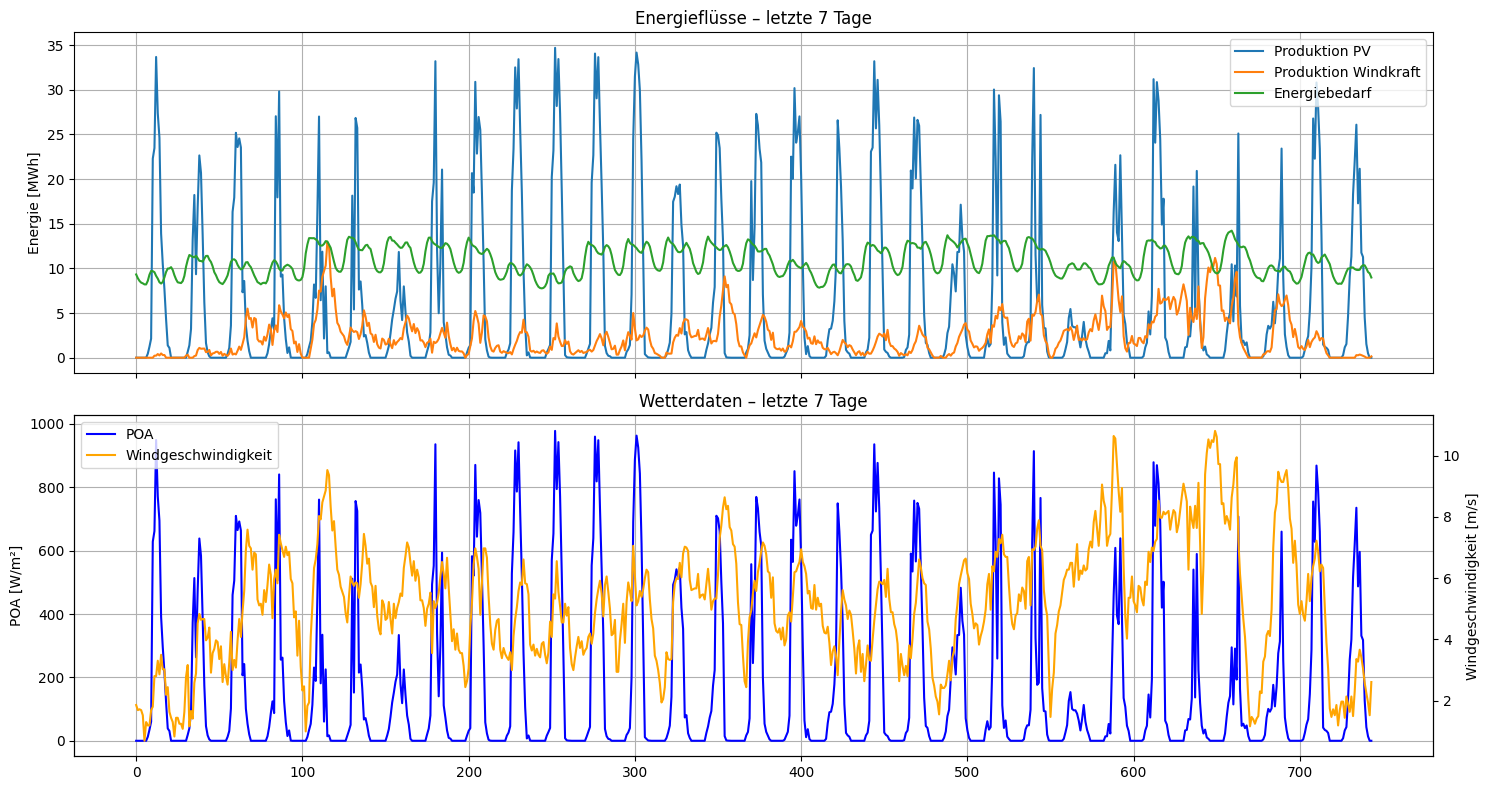

In [44]:
df_plot = df_merged.copy()

# Figure mit zwei Subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Energieflüsse
ax1.plot(df_plot.index, df_plot["solar_energy_production"], label="Produktion PV")
ax1.plot(df_plot.index, df_plot["wind_energy_production"], label="Produktion Windkraft")
ax1.plot(df_plot.index, df_plot["energy_demand"], label="Energiebedarf")
ax1.set_ylabel("Energie [MWh]")
ax1.set_title("Energieflüsse – letzte 7 Tage")
ax1.legend()
ax1.grid(True)

# Wetterdaten
ax2a = ax2  # linke Achse
ax2b = ax2a.twinx()  # rechte Achse

line1, = ax2a.plot(df_plot.index, df_plot["poa_irradiance"], color="blue", label="POA")
line2, = ax2b.plot(df_plot.index, df_plot["windspeed"] / 3.6, color="orange", label="Windgeschwindigkeit")

ax2a.set_ylabel("POA [W/m²]")
ax2a.tick_params(axis='y')
ax2b.set_ylabel("Windgeschwindigkeit [m/s]")
ax2b.tick_params(axis='y')
ax2a.set_title("Wetterdaten – letzte 7 Tage")

# Gemeinsame Legende unten
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax2.grid(True)
ax2a.legend(lines, labels, loc="upper left")

plt.xlabel("Zeit")
plt.tight_layout()
plt.show()


**Ausführen der regelbasierten und optimierten Funktion**

In [45]:
result_df_rule = rule_based_energy_flow(
    df_merged, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, price_low_quant
    )

result_df_opt = optimize_energy_flow(
    df_merged, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, 
    window_days, step_hours
    )

result_kpis_opt = calculate_kpis(result_df_opt, export_factor)
result_kpis_rule = calculate_kpis(result_df_rule, export_factor)

**Ausgabe der wichtigsten KPIs zum quanitiativen Vergleich der Performance**

In [46]:
#Ausgaben 
print("Regelbasiert:")
print(f"Netto Stromkosten: {result_kpis_rule['Netto Stromkosten']:.2f} €")
print(f"Netzstromkosten: {result_kpis_rule['Netzstromkosten']:.2f} €")
print(f"Einspeisevergütung: {result_kpis_rule['Einspeisevergütung']:.2f} €")
wavg_price_rule = (result_df_rule["spotprice_EUR_per_MWh"] * result_df_rule["ee_export_MWh"]).sum() / max(result_kpis_rule["Einspeisung"], 1e-9)
print(f"Export-gewichteter Preis (rule): {wavg_price_rule:.2f} €/MWh")
print(f"Netzbezug: {result_kpis_rule['Netzbezug']:.2f} MWh")
print(f"Einspeisung: {result_kpis_rule['Einspeisung']:.2f} MWh")
print(f"Batterieladung: {result_kpis_rule['Batterieladung']:.2f} MWh")
print(f"Batterieentladung: {result_kpis_rule['Batterieentladung']:.2f} MWh")

print("----------------------")

print("Optimiert:")
print(f"Netto Stromkosten: {result_kpis_opt['Netto Stromkosten']:.2f} €")
print(f"Netzstromkosten: {result_kpis_opt['Netzstromkosten']:.2f} €")
print(f"Einspeisevergütung: {result_kpis_opt['Einspeisevergütung']:.2f} €")
wavg_price_opt = (result_df_opt["spotprice_EUR_per_MWh"] * result_df_opt["ee_export_MWh"]).sum() / max(result_kpis_opt["Einspeisung"], 1e-9)
print(f"Export-gewichteter Preis (opt):  {wavg_price_opt:.2f} €/MWh")
print(f"Netzbezug: {result_kpis_opt['Netzbezug']:.2f} MWh")
print(f"Einspeisung: {result_kpis_opt['Einspeisung']:.2f} MWh")
print(f"Batterieladung: {result_kpis_opt['Batterieladung']:.2f} MWh")
print(f"Batterieentladung: {result_kpis_opt['Batterieentladung']:.2f} MWh")

print("----------------------")

# Differenz Optimiert - Regelbasiert
diff_eur = result_kpis_opt["Netto Stromkosten"] - result_kpis_rule["Netto Stromkosten"]
rel_pct  = diff_eur / result_kpis_rule["Netto Stromkosten"] * 100
demand_MWh = result_df_opt["demand_MWh"].sum()  # Referenz für ct/kWh

print(f"Einsparungspotenzial: {diff_eur:.2f} € ({rel_pct:.2f} %)")
months = len(df_weather) / 24
saving_per_month = diff_eur / months
print(f"Ø tägliche Einsparung: {saving_per_month:.2f} €")



Regelbasiert:
Netto Stromkosten: 367512.72 €
Netzstromkosten: 360115.96 €
Einspeisevergütung: -7396.76 €
Export-gewichteter Preis (rule): -14.48 €/MWh
Netzbezug: 3979.39 MWh
Einspeisung: 2043.97 MWh
Batterieladung: 473.95 MWh
Batterieentladung: 479.95 MWh
----------------------
Optimiert:
Netto Stromkosten: 315716.08 €
Netzstromkosten: 303883.27 €
Einspeisevergütung: -11832.80 €
Export-gewichteter Preis (opt):  -13.83 €/MWh
Netzbezug: 5356.76 MWh
Einspeisung: 3421.33 MWh
Batterieladung: 823.03 MWh
Batterieentladung: 829.03 MWh
----------------------
Einsparungspotenzial: -51796.65 € (-14.09 %)
Ø tägliche Einsparung: -1670.86 €


**Plot der Energieflüsse zum qualitativen Vergleich der Performance**

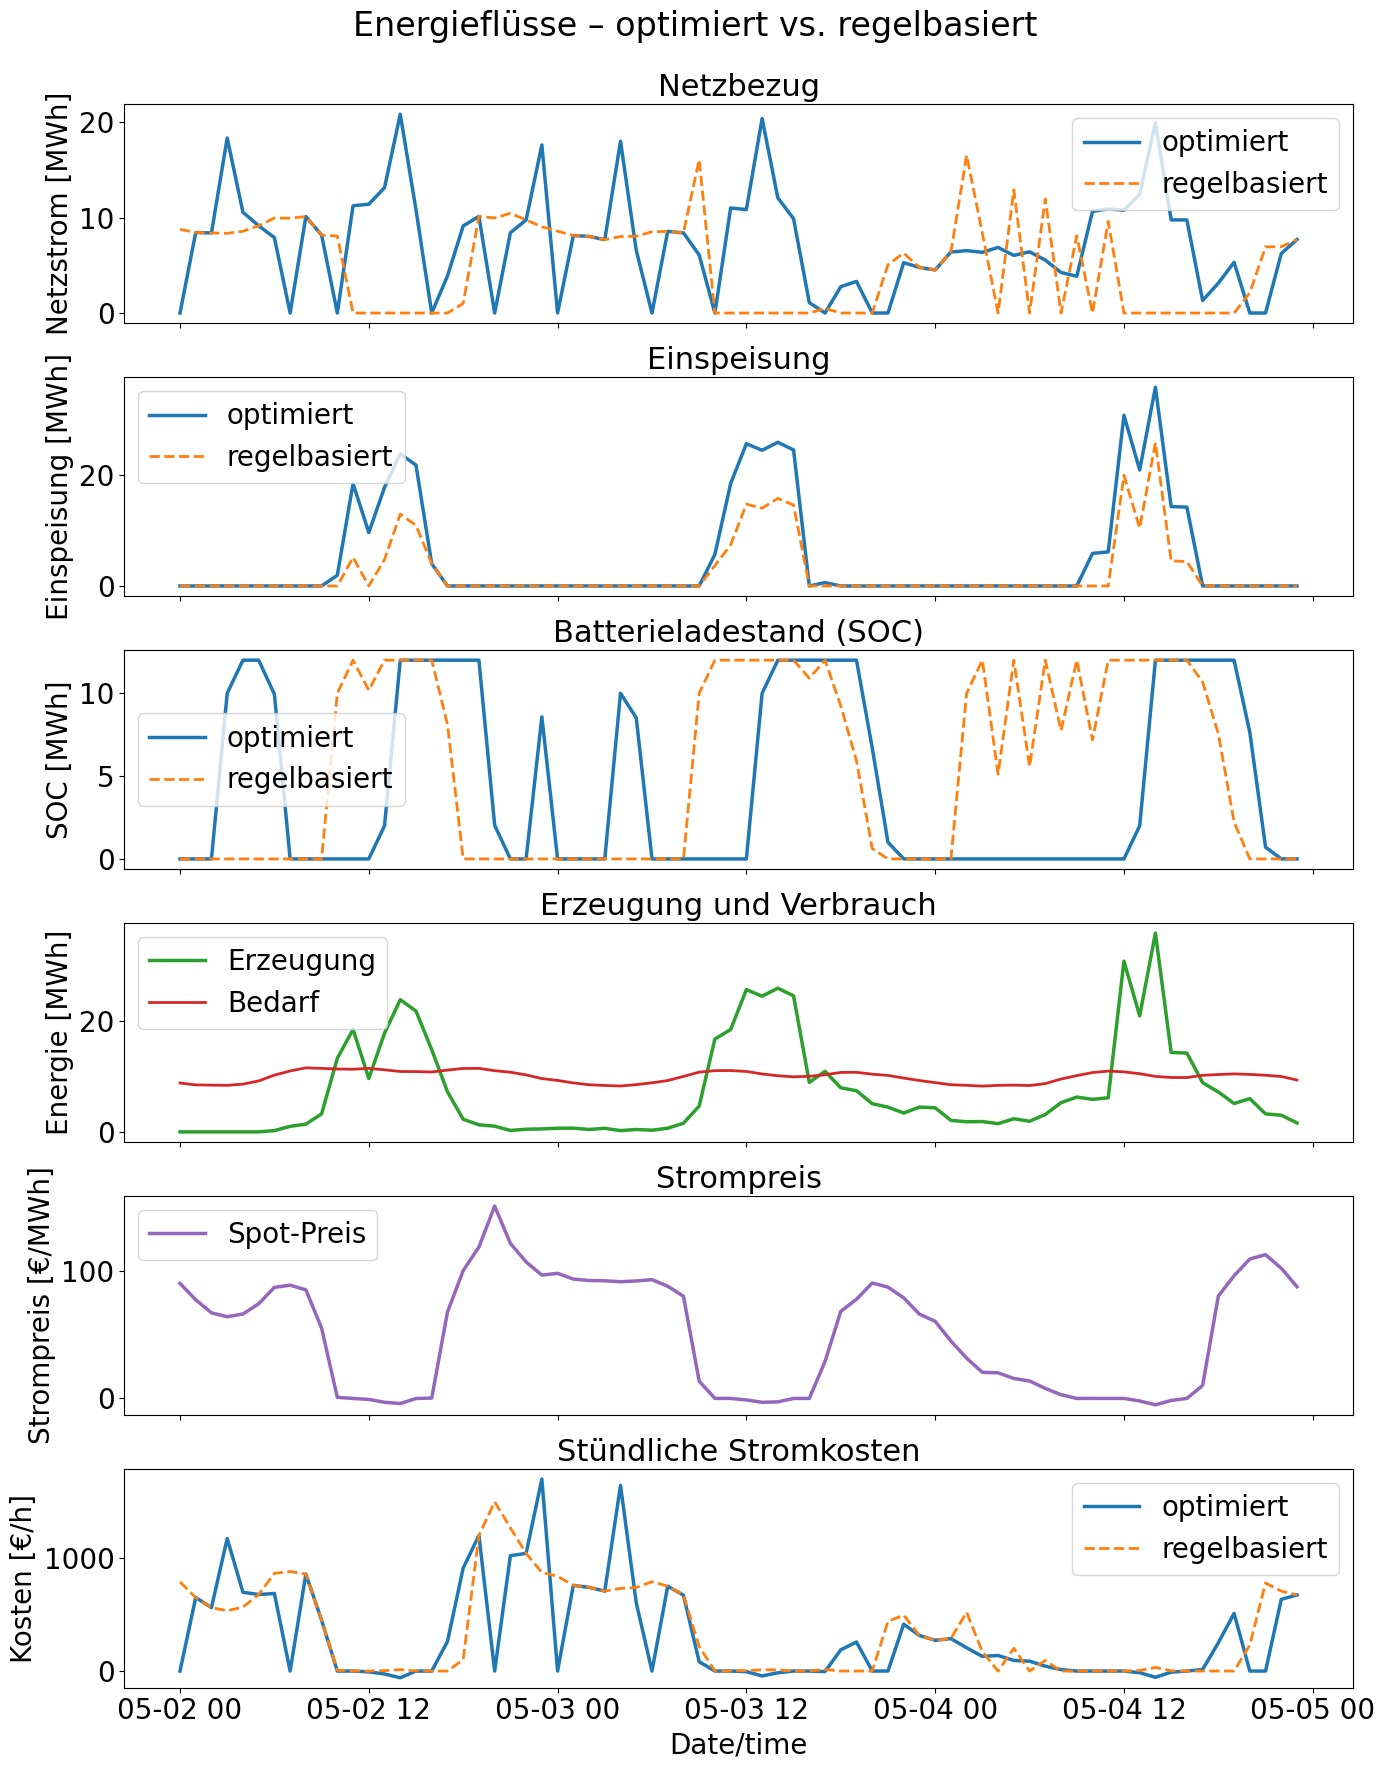

In [47]:
# Zeitspalten
result_df_opt["datetime"] = pd.to_datetime(result_df_opt["datetime"])
result_df_rule["datetime"] = pd.to_datetime(result_df_rule["datetime"])

# Kopien + Hilfsspalten
opt  = result_df_opt.copy()
rule = result_df_rule.copy()
for df in (opt, rule):
    df["grid_buy"]       = df["grid_to_load_MWh"] + df["grid_to_batt_MWh"]
    df["battery_state"]  = df["SOC_MWh"]
    df["grid_feed_in"]   = df["ee_export_MWh"]
    # stündliche Kosten (€/h)
    df["hourly_cost_EUR"] = (
        (df["grid_to_load_MWh"] + df["grid_to_batt_MWh"]) * df["spotprice_EUR_per_MWh"]
        - export_factor * df["ee_export_MWh"] * df["spotprice_EUR_per_MWh"]
    )

# Zeitfenster
start_time = opt["datetime"].min() + pd.Timedelta(days=1)
end_time   = start_time + pd.Timedelta(days=3)
opt  = opt[(opt["datetime"] >= start_time) & (opt["datetime"] < end_time)]
rule = rule[(rule["datetime"] >= start_time) & (rule["datetime"] < end_time)]

# Styles
label_fontsize = 20
tick_fontsize  = 20
legend_fontsize= 20
title_fontsize = 22
c_opt  = "tab:blue"
c_rule = "tab:orange"
c_gen  = "tab:green"
c_dem  = "tab:red"
c_prc  = "tab:purple"

# Plot (jetzt 6 Panels inkl. Kosten)
fig, axs = plt.subplots(6, 1, figsize=(14, 18), sharex=True)
fig.suptitle("Energieflüsse – optimiert vs. regelbasiert", fontsize=title_fontsize+2)

# 1) Netzbezug
axs[0].set_title("Netzbezug", fontsize=title_fontsize)
axs[0].plot(opt["datetime"],  opt["grid_buy"],  label="optimiert", color=c_opt, linewidth=2.5)
axs[0].plot(rule["datetime"], rule["grid_buy"], label="regelbasiert", color=c_rule, linestyle="--", linewidth=2)
axs[0].set_ylabel("Netzstrom [MWh]", fontsize=label_fontsize)
axs[0].legend(fontsize=legend_fontsize)
axs[0].tick_params(axis='both', labelsize=tick_fontsize)

# 2) Einspeisung
axs[1].set_title("Einspeisung", fontsize=title_fontsize)
axs[1].plot(opt["datetime"],  opt["grid_feed_in"],  label="optimiert", color=c_opt, linewidth=2.5)
axs[1].plot(rule["datetime"], rule["grid_feed_in"], label="regelbasiert", color=c_rule, linestyle="--", linewidth=2)
axs[1].set_ylabel("Einspeisung [MWh]", fontsize=label_fontsize)
axs[1].legend(fontsize=legend_fontsize)
axs[1].tick_params(axis='both', labelsize=tick_fontsize)

# 3) Batteriezustand
axs[2].set_title("Batterieladestand (SOC)", fontsize=title_fontsize)
axs[2].plot(opt["datetime"],  opt["battery_state"],  label="optimiert", color=c_opt, linewidth=2.5)
axs[2].plot(rule["datetime"], rule["battery_state"], label="regelbasiert", color=c_rule, linestyle="--", linewidth=2)
axs[2].set_ylabel("SOC [MWh]", fontsize=label_fontsize)
axs[2].legend(fontsize=legend_fontsize)
axs[2].tick_params(axis='both', labelsize=tick_fontsize)

# 4) Erzeugung und Verbrauch
axs[3].set_title("Erzeugung und Verbrauch", fontsize=title_fontsize)
axs[3].plot(opt["datetime"], opt["EE_total_MWh"], label="Erzeugung", color=c_gen, linewidth=2.5)
axs[3].plot(opt["datetime"], opt["demand_MWh"],     label="Bedarf",    color=c_dem, linewidth=2)
axs[3].set_ylabel("Energie [MWh]", fontsize=label_fontsize)
axs[3].legend(fontsize=legend_fontsize)
axs[3].tick_params(axis='both', labelsize=tick_fontsize)

# 5) Strompreis
axs[4].set_title("Strompreis", fontsize=title_fontsize)
axs[4].plot(opt["datetime"], opt["spotprice_EUR_per_MWh"], label="Spot-Preis", color=c_prc, linewidth=2.5)
axs[4].set_ylabel("Strompreis [€/MWh]", fontsize=label_fontsize)
axs[4].legend(fontsize=legend_fontsize)
axs[4].tick_params(axis='both', labelsize=tick_fontsize)

# 6) Stündliche Stromkosten
axs[5].set_title("Stündliche Stromkosten", fontsize=title_fontsize)
axs[5].plot(opt["datetime"],  opt["hourly_cost_EUR"],  label="optimiert", color=c_opt, linewidth=2.5)
axs[5].plot(rule["datetime"], rule["hourly_cost_EUR"], label="regelbasiert", color=c_rule, linestyle="--", linewidth=2)
axs[5].set_ylabel("Kosten [€/h]", fontsize=label_fontsize)
axs[5].legend(fontsize=legend_fontsize)
axs[5].tick_params(axis='both', labelsize=tick_fontsize)

plt.xlabel("Date/time", fontsize=label_fontsize)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
